<a href="https://colab.research.google.com/github/MSaber7/Machine-Learning/blob/master/SR-SpeechSignalProc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SR | Lab Two: Speech Signal Processing


In this lab, you will write the core functions necessary to perform feature extraction on audio waveforms. Your program will convert an audio file to a sequence of log mel frequency filterbank ("FBANK") coefficients.
The basic steps in features extraction are:
Dithering & pre-emphasis of the waveform
Dividing the signal into overlapping segments or frames
For each frame of audio:
Windowing the frame
Computing the magnitude spectrum of the frame
Applying the mel filterbank to the spectrum to create mel filterbank coefficient
Applying a logarithm operation to the mel filterbank coefficient
File speech_sigproc.py contains methods for performing these steps. Functions for dithering (1a), framing (2) and windowing (3a) are already implemented as well as method process_utterance which applies all needed methods one after another. Your task is to:
Implement pre-emphasis of the signal as method pre_emphasize 
Implement computation of magnitude spectrum as method frames_to_magspec. (Note: the variable fft_size is useful there)
Implement the application of mel filterbank and logarithm operation as method magspec_to_fbank (Note: the coefficients of the melt filterbank are computed and saved as mel_filterbank 2-D array. 

The lab also contain following files:
1272-128104-0000.flac -- audio file from LibriSpeech library, which is a clean sample of english speech
1272-128104-0000.feat -- file which contains data about expected result of feature extraction for mentioned audio file 
htk_featio.py -- additional file for extracting data from .feat file
plotter.py -- script which consistently performs following steps:
Reads the wav file and extracts features from it with method process_utterance from speech_sigproc.py 
Plot the original waveform, the mel filterbank, the expected and gained results of feature extraction
Computes per-element absolute error of the feature extraction (Note: if you did everything correctly, the expected error is less than 1e-08).


# Library

In [2]:
!pip install SoundFile

In [0]:
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import htk_featio as htk
import speech_sigproc as sp
from IPython.display import Image, display


### speech_sigproc

In [0]:
class FrontEnd:

    def __init__(self, samp_rate=16000, frame_duration=0.025, frame_shift=0.010, preemphasis=0.97,
                 num_mel=40, lo_freq=0, hi_freq=None, mean_norm_feat=False, mean_norm_wav=True, compute_stats=False):
        self.samp_rate = samp_rate
        self.win_size = int(np.floor(frame_duration * samp_rate))
        self.win_shift = int(np.floor(frame_shift * samp_rate))
        self.lo_freq = lo_freq
        if (hi_freq == None):
            self.hi_freq = samp_rate//2
        else:
            self.hi_freq = hi_freq

        self.preemphasis = preemphasis
        self.num_mel = num_mel
        self.fft_size = 2
        while (self.fft_size<self.win_size):
            self.fft_size *= 2

        self.hamwin = np.hamming(self.win_size)

        self.make_mel_filterbank()
        self.zero_mean_wav = mean_norm_wav
        self.global_mean = np.zeros([num_mel])
        self.global_var = np.zeros([num_mel])
        self.global_frames = 0
        self.compute_global_stats = compute_stats

    # linear-scale frequency (Hz) to mel-scale frequency
    def lin2mel(self,freq):
        return 2595*np.log10(1+freq/700)

    # mel-scale frequency to linear-scale frequency
    def mel2lin(self,mel):
        return (10**(mel/2595)-1)*700

    def make_mel_filterbank(self):

        lo_mel = self.lin2mel(self.lo_freq)
        hi_mel = self.lin2mel(self.hi_freq)

        # uniform spacing on mel scale
        mel_freqs = np.linspace(lo_mel, hi_mel,self.num_mel+2)

        # convert mel freqs to hertz and then to fft bins
        bin_width = self.samp_rate/self.fft_size # typically 31.25 Hz, bin[0]=0 Hz, bin[1]=31.25 Hz,..., bin[256]=8000 Hz
        mel_bins = np.floor(self.mel2lin(mel_freqs)/bin_width)

        num_bins = self.fft_size//2 + 1
        self.mel_filterbank = np.zeros([self.num_mel,num_bins])
        for i in range(0,self.num_mel):
            left_bin = int(mel_bins[i])
            center_bin = int(mel_bins[i+1])
            right_bin = int(mel_bins[i+2])
            up_slope = 1/(center_bin-left_bin)
            for j in range(left_bin,center_bin):
                self.mel_filterbank[i,j] = (j - left_bin)*up_slope
            down_slope = -1/(right_bin-center_bin)
            for j in range(center_bin,right_bin):
                self.mel_filterbank[i,j] = (j-right_bin)*down_slope

    def plot_mel_matrix(self):
        for i in range(0, self.num_mel):
            plt.plot(self.mel_filterbank[i,:])
        plt.show()

    def dither(self, wav):
        n = 2*np.random.rand(wav.shape[0])-1
        n *= 1/(2**15)
        return wav + n

    # replace this with proper pre-emphasis filtering, using the self.preemphasis coefficient
    def pre_emphasize(self, wav):
        # apply pre-emphasis filtering on waveform
        preemph_wav = []
        return preemph_wav

    def wav_to_frames(self, wav):
        # wav1 = np.array(wav)
        # only process whole frames
        num_frames = int(np.floor((wav.shape[0] - self.win_size) / self.win_shift) + 1)
        frames = np.zeros([self.win_size, num_frames])
        for t in range(0, num_frames):
            frame = wav[t * self.win_shift:t * self.win_shift + self.win_size]
            if (self.zero_mean_wav):
                frame = frame - np.mean(frame)
            frames[:, t] = self.hamwin * frame
        return frames

    # for each frame (column of 2D array 'frames'), compute the magnitude spectrum using the fft
    def frames_to_magspec(self, frames):
        # compute the fft
        # compute magnitude
        magspec = []
        return magspec

    # for each frame(column of 2D array 'magspec'), compute the log mel spectrum, by applying the mel filterbank to the magnitude spectrum
    def magspec_to_fbank(self, magspec):
        # apply the mel filterbank
        fbank = []
        return fbank

    def process_utterance(self, utterance):
   #     plt.plot(utterance)
   #     plt.show()
        wav     = self.dither(utterance)
        wav     = self.pre_emphasize(wav)
        frames  = self.wav_to_frames(wav)
        magspec = self.frames_to_magspec(frames)
        fbank   = self.magspec_to_fbank(magspec)
        return fbank

### htk_featio 

In [0]:
def write_htk_user_feat(x, name='filename'):
    default_period = 100000 # assumes 0.010 ms frame shift
    num_dim = x.shape[0]
    num_frames = x.shape[1]
    hdr = struct.pack(
        '>iihh',  # the beginning '>' says write big-endian
        num_frames,  # nSamples
        default_period,  # samplePeriod
        4*num_dim,  # 2 floats per feature
        9)  # user features

    out_file = open(name, 'wb')
    out_file.write(hdr)

    for t in range(0, num_frames):
        frame = np.array(x[:,t],'f')
        if sys.byteorder == 'little':
            frame.byteswap(True)
        frame.tofile(out_file)

    out_file.close()

def read_htk_user_feat(name='filename'):
    f = open(name,'rb')
    hdr = f.read(12)
    num_samples, samp_period, samp_size, parm_kind = struct.unpack(">IIHH", hdr)
    if parm_kind != 9:
        raise RuntimeError('feature reading code only validated for USER feature type for this lab. There is other publicly available code for general purpose HTK feature file I/O\n')

    num_dim = samp_size//4

    feat = np.zeros([num_samples, num_dim],dtype=float)
    for t in range(num_samples):
        feat[t,:] = np.array(struct.unpack('>' + ('f' * num_dim), f.read(samp_size)),dtype=float)

    return feat


def write_ascii_stats(x,name='filename'):
    out_file = open(name,'w')
    for t in range(0, x.shape[0]):
        out_file.write("{0}\n".format(x[t]))
    out_file.close()

# Plotter

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
%cd/content/drive/My Drive/Colab Notebooks/SR/Lab2

/content/drive/My Drive/Colab Notebooks/SR/Lab2


In [20]:
wav_file='1272-128104-0000.flac'
feat_file=('1272-128104-0000.feat')

if not os.path.isfile(wav_file):
    raise RuntimeError('input wav file is missing.')

samp_rate = 16000

x, s = sf.read(wav_file)
if (s != samp_rate):
    raise RuntimeError("WAV file is 16000 Hz, found {0}".format(s))

fe = sp.FrontEnd(samp_rate=samp_rate,mean_norm_feat=True)


feat = fe.process_utterance(x)

if not os.path.exists('fig'):
    os.mkdir('fig')

# plot waveform
plt.plot(x)
plt.title('waveform')
plt.savefig('fig/waveform.png', bbox_inches='tight')
plt.close()

# plot mel filterbank
for i in range(0, fe.num_mel):
    plt.plot(fe.mel_filterbank[i, :])
plt.title('mel filterbank')
plt.savefig('fig/mel_filterbank.png', bbox_inches='tight')
plt.close()

# plot log mel spectrum (fbank)
plt.imshow(feat, origin='lower', aspect=4) # flip the image so that vertical frequency axis goes from low to high
plt.title('log mel filterbank features (fbank)')
plt.savefig('fig/fbank.png', bbox_inches='tight')
plt.close()

htk.write_htk_user_feat(feat, feat_file)
print("Wrote {0} frames to {1}".format(feat.shape[1], feat_file))

# if you want to verify, that the file was written correctly:
feat2 = htk.read_htk_user_feat(name=feat_file).transpose()
print("Read {0} frames rom {1}".format(feat2.shape[1], feat_file))
print("Per-element absolute error is {0}".format(np.linalg.norm(feat-feat2)/(feat2.shape[0]*feat2.shape[1])))

plt.imshow(feat2, origin='lower', aspect=4)  # flip the image so that vertical frequency axis goes from low to high
plt.title('Expected log mel filterbank features')
plt.savefig('fig/fbank_exp.png', bbox_inches='tight')
plt.close()


400
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape of frame: (257,)
shape o

# Visualization

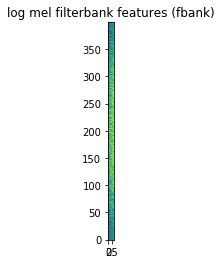

In [23]:
display(Image('fig/fbank.png'))

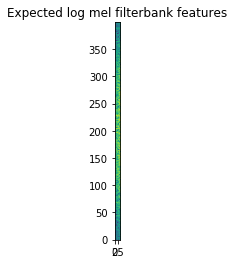

In [24]:
Image('fig/fbank_exp.png')

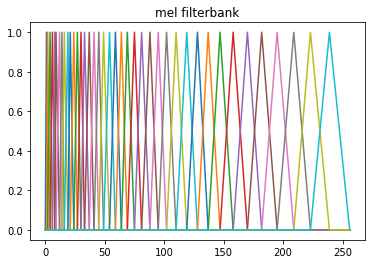

In [25]:
Image('fig/mel_filterbank.png')

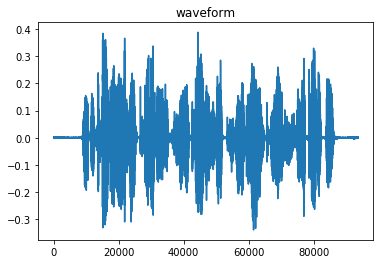

In [26]:
Image('fig/waveform.png')